<a href="https://www.kaggle.com/code/testanother/feature-importance-on-interview-questions?scriptVersionId=129438284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from xgboost import plot_importance
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter

## Purpose of the Notebook

This notebook will go over the coding challenge data from leetcode data and try to make an analysis on the questions asked by Faang companies. 

It will do classification on asked_by_faang variable and will try to create a model and predict if an interview question will be asked by the faang companies.

In [2]:
df = pd.read_csv('/kaggle/input/leetcode-problem-dataset/leetcode_dataset - lc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1825 non-null   int64  
 1   title              1825 non-null   object 
 2   description        1825 non-null   object 
 3   is_premium         1825 non-null   int64  
 4   difficulty         1825 non-null   object 
 5   solution_link      987 non-null    object 
 6   acceptance_rate    1825 non-null   float64
 7   frequency          1825 non-null   float64
 8   url                1825 non-null   object 
 9   discuss_count      1825 non-null   int64  
 10  accepted           1825 non-null   object 
 11  submissions        1825 non-null   object 
 12  companies          1749 non-null   object 
 13  related_topics     1571 non-null   object 
 14  likes              1825 non-null   int64  
 15  dislikes           1825 non-null   int64  
 16  rating             1825 

# Preprocessing

Lets take a look at the variables...

## Variable to predict

This is easy and it is the 'asked_by_faang' flag. We already know that it is an integer (1 if true, 0 if false). 

Lets take a look at the distribution of the variable (how many entries etc)...

In [3]:
df.asked_by_faang.value_counts()

1    1225
0     600
Name: asked_by_faang, dtype: int64

([<matplotlib.patches.Wedge at 0x7ae0a4dff250>,
 [Text(-0.5636085606106039, 0.9446403497662184, 'Asked by faang'),
  Text(0.5636085606106042, -0.9446403497662182, 'Not asked by faang')],
 [Text(-0.3074228512421476, 0.5152583725997554, '67.1%'),
  Text(0.3074228512421477, -0.5152583725997554, '32.9%')])

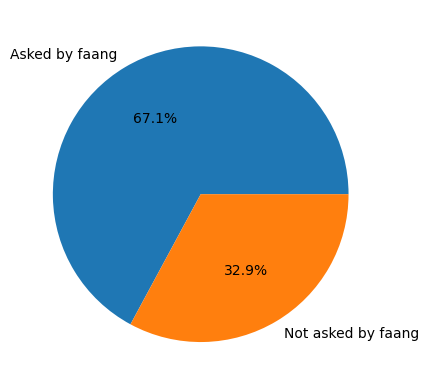

In [4]:
plt.pie(df.asked_by_faang.value_counts(), labels=['Asked by faang', 'Not asked by faang'], autopct='%1.1f%%')

### Intuition

The classification is imbalanced. Meaning that we will have to oversample or undersample the training data

## Null Values

We also need to see if we have null values to see if we have to handle them or not.

In [5]:
df.isnull().sum()

id                      0
title                   0
description             0
is_premium              0
difficulty              0
solution_link         838
acceptance_rate         0
frequency               0
url                     0
discuss_count           0
accepted                0
submissions             0
companies              76
related_topics        254
likes                   0
dislikes                0
rating                  0
asked_by_faang          0
similar_questions    1080
dtype: int64

Columns solution_link, companies, related_topics and similar_questions seems to have null values. 

The "companies" field is not interesting because we are trying to see if a question is asked by faang company so we will drop it along with id, url, solution_link and url fields. 

We also do not need the description field. It will be helpful if we want to, maybe, create a language model but there is no need to have it now.

The field "related questions" however is interesting. We can create a category of questions from that one.

## Related Topics

The related topics field is interesting because it is detailing which topics the questions was about. So dropping it would mean to loose lots of data. 

But we can convert the data to categorical data and treat it as such so here is what we will do: 

1. Gather all the topics so we have a list that is for example \[topic1, topic2 ...\]
2. Create columns and add them to the dataset
3. If the related_topics column has that topic, set the value to 1

In [6]:
def find_unique_related_topic_values(topics):
    res = set()
    for t in topics:
        split = t.split(',')
        if len(split) != 2:
            continue
        res.add(split[0])
        res.add(split[1])
    return res

def create_columns(data, cols):
    for c in cols:
        data[c] = 0
    return data

def set_related_topic_cols(data, cols, topic_name='related_topics'):
    for c in cols:
        data[c] = data[topic_name].fillna('').apply(lambda x: 1 if c in x else 0)

In [7]:
related_question_topics = find_unique_related_topic_values(df['related_topics'].fillna(''))
related_question_topics

{'Array',
 'Backtracking',
 'Binary Indexed Tree',
 'Binary Search',
 'Binary Search Tree',
 'Bit Manipulation',
 'Brainteaser',
 'Breadth-first Search',
 'Depth-first Search',
 'Design',
 'Divide and Conquer',
 'Dynamic Programming',
 'Geometry',
 'Graph',
 'Greedy',
 'Hash Table',
 'Heap',
 'Line Sweep',
 'Linked List',
 'Math',
 'Meet in the Middle',
 'Minimax',
 'Ordered Map',
 'Queue',
 'Random',
 'Recursion',
 'Rejection Sampling',
 'Rolling Hash',
 'Segment Tree',
 'Sliding Window',
 'Sort',
 'Stack',
 'String',
 'Suffix Array',
 'Topological Sort',
 'Tree',
 'Trie',
 'Two Pointers',
 'Union Find'}

In [8]:
# It is always a good idea to copy the dataframe in case things go bad
df_copy = df.copy()

In [9]:
create_columns(df_copy, related_question_topics)
set_related_topic_cols(df_copy, related_question_topics)

In [10]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 58 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1825 non-null   int64  
 1   title                 1825 non-null   object 
 2   description           1825 non-null   object 
 3   is_premium            1825 non-null   int64  
 4   difficulty            1825 non-null   object 
 5   solution_link         987 non-null    object 
 6   acceptance_rate       1825 non-null   float64
 7   frequency             1825 non-null   float64
 8   url                   1825 non-null   object 
 9   discuss_count         1825 non-null   int64  
 10  accepted              1825 non-null   object 
 11  submissions           1825 non-null   object 
 12  companies             1749 non-null   object 
 13  related_topics        1571 non-null   object 
 14  likes                 1825 non-null   int64  
 15  dislikes             

So now we have some more columns which can tell us what topic was the question related to. 

## Converting the numbers represented as strings 

There are entries such as 1.2M at the accepted and submissions columns. We need to represent them as number too

I have taken the conversion from https://stackoverflow.com/questions/39684548/convert-the-string-2-90k-to-2900-or-5-2m-to-5200000-in-pandas-dataframe

In [11]:
def convert_string_to_numeric(data, columns=['accepted', 'submissions']):
    for c in columns:
        df_copy[c] = df[c].replace(r'[KM]+$', '', regex=True).astype(float) * df[c].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

In [12]:
convert_string_to_numeric(df_copy)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 58 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1825 non-null   int64  
 1   title                 1825 non-null   object 
 2   description           1825 non-null   object 
 3   is_premium            1825 non-null   int64  
 4   difficulty            1825 non-null   object 
 5   solution_link         987 non-null    object 
 6   acceptance_rate       1825 non-null   float64
 7   frequency             1825 non-null   float64
 8   url                   1825 non-null   object 
 9   discuss_count         1825 non-null   int64  
 10  accepted              1825 non-null   float64
 11  submissions           1825 non-null   float64
 12  companies             1749 non-null   object 
 13  related_topics        1571 non-null   object 
 14  likes                 1825 non-null   int64  
 15  dislikes             

## Difficulty

Difficulty can be interpreted as categorical values. So we can use one hot encoder for sklearn

In [13]:
def convert_difficulty(data, column_name='difficulty'):
    enc = OneHotEncoder()
    enc_data = pd.DataFrame(enc.fit_transform(data[[column_name]]).toarray())
    print(enc.get_feature_names(['difficulty']))
    df_encoded = data.join(enc_data)
    return df_encoded

In [14]:
df_encoded = convert_difficulty(df_copy)
df_encoded.info()

['difficulty_Easy' 'difficulty_Hard' 'difficulty_Medium']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1825 non-null   int64  
 1   title                 1825 non-null   object 
 2   description           1825 non-null   object 
 3   is_premium            1825 non-null   int64  
 4   difficulty            1825 non-null   object 
 5   solution_link         987 non-null    object 
 6   acceptance_rate       1825 non-null   float64
 7   frequency             1825 non-null   float64
 8   url                   1825 non-null   object 
 9   discuss_count         1825 non-null   int64  
 10  accepted              1825 non-null   float64
 11  submissions           1825 non-null   float64
 12  companies             1749 non-null   object 
 13  related_topics        1571 non-null   object 
 14  likes         

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


So Easy is 0, Hard is 1 and medium is 2

## Dropping the unnecessary columns 

Now we can simply remove the columns that is not necessary

In [15]:
drop_columns = ['id', 'title', 'description', 'difficulty', 'solution_link', 'url', 'companies', 'related_topics', 'similar_questions']
df_encoded.drop(columns=drop_columns, inplace=True)

# Modeling 

This process is straigtforward. I will split the data into train and test and then train a classifier

In [16]:
X, y = df_encoded.drop(columns=['asked_by_faang']), df_encoded['asked_by_faang']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# scale the train set up to have a balance classification
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [18]:
# See if it worked
Counter(y_res)

Counter({1: 834, 0: 834})

In [19]:
numeric_features = X_res.columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

model = XGBClassifier(objective='binary:logistic', random_state=42)

clf = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', model)
])

In [20]:
clf.fit(X_res, y_res)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index([          'is_premium',      'acceptance_rate',            'frequency',
              'discuss_count',             'accepted',          'submissions',
                      'likes',             'dislikes',               'rating',
         'Depth-first Search',  'Binary Indexed Tree',            'Recursion',
                      'Array',          'Linked Li...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_cons

In [21]:
clf.score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.6666666666666666

The model has a 66% accuracy. This is not bad but could be way better. 

We can do randomized search to find better parameters for the classfier too but that is future work for now

In [22]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


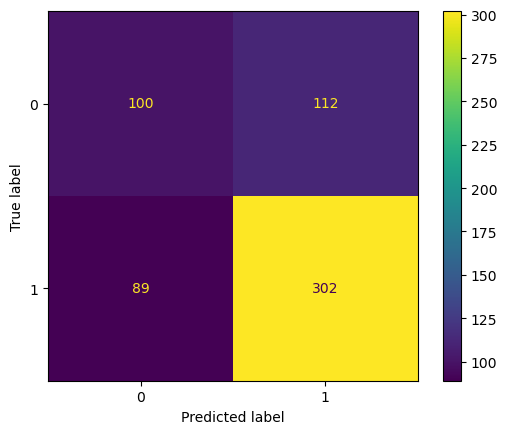

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

The model is not that great at identifying the true negatives (112 entries were not asked by faang companies but was predicted as asked by faang companies

# Feature Importance

We now can use feature importance on the trained model. I will use the SHAP library https://shap.readthedocs.io/en/latest/index.html

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


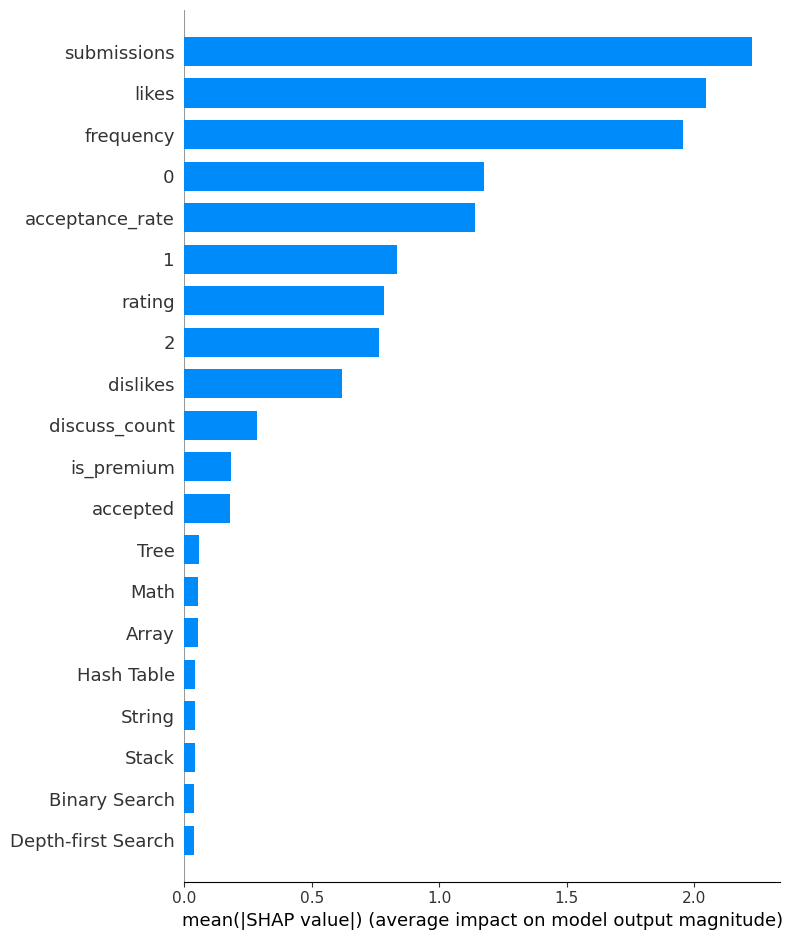

In [24]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_res)
shap.summary_plot(shap_values, X_res, plot_type="bar")

# Final Thoughts 

So there it is. We have trained a model and made feature analysis on it. It seems like submissions, likes and frequency effects the probability of a question being asked by a faang company. This is not surprising since I assume people just try to solve questions that are asked by large tech companies. 

However if you want to practice, concentrate on questions that are easy (0 is the feature name) and hard (1 is the feature name) since they also have an effect on the result. 

# Improvement Ideas

1. Code should be more modularized. I have omitted doing this but it can be done to make things easier for the future use 
2. RandomizedSearch on the model. You can try this and see what the result becomes